<a href="https://colab.research.google.com/github/Mathieu-van-Luijken/Transfer-Learning-for-Predictive-Process-Monitoring-/blob/main/hw3generative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import math
import torch
import torch.nn as nn
import torch.utils 
from torch.nn import Sigmoid
from torch.optim import Adam
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
#Loading in the data
dataset_path = '~/datasets'
batch_size = 100

mnist_transform = transforms.Compose([
        transforms.ToTensor(),])

kwargs = {'num_workers': 1, 'pin_memory': True} 


train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_data = torch.utils.data.Subset(train_dataset, range(0,50000))
val_data = torch.utils.data.Subset(train_dataset, range(50000, 60000))

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, **kwargs)
vali_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [7]:

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()
    def forward(self,x):
        return x[:, :, :28, :28]



In [8]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.z_mean = torch.nn.Linear(8*8*64, 10)
        self.z_var =nn.Sequential(
            torch.nn.Linear(8*8*64, 10),
            torch.nn.Softplus())


        
        self.decoder = nn.Sequential(
            torch.nn.Linear(10, 8*8*64),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),            
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride = (1, 1),  padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2 output channels, one for mu one for sigma
            # alternatively one for beta one for alpha
            nn.ConvTranspose2d(32, 1, kernel_size=(3, 3), stride = (1, 1), padding=0),
            # this for gauss (i guess)
            # nn.Sigmoid()
            # this for beta
            Trim(),
            nn.Softplus()
        )
    
    def reparametization(self, z_mu, z_var):
        #batch_mu_z + torch.sqrt(batch_var_z) * torch.randn(batch_var_z.shape, device=device)
        z = z_mu + torch.sqrt(z_var)*torch.randn(z_var.shape,device=device)
        #eps = torch.randn_like(torch.exp(z_log_var),device=device)
        #z = z_mu + torch.exp(z_log_var) * eps

        return z
  
    
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_var = self.z_mean(x), self.z_var(x)
        encoded = self.reparametization(z_mean, z_var)
        decoded = self.decoder(encoded)
        return decoded, z_mean, z_var

In [11]:
vae = VAE().to(device)

def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=0.005)

In [12]:
epochs = 50

print("Start training VAE...")
start_time = time.time()
vae.train()

train_ELBO = []
validation_ELBO = []

for epoch in range(epochs):
    
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):

        optimizer.zero_grad()
        x = x.to(device)
        x_reconstr, mu, log_sigma = vae(x)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
        
        
    n_datapoints = batch_idx * batch_size
    train_ELBO.append(overall_loss/n_datapoints)
    
    with torch.no_grad():
        validation_loss = 0
        validation_reconstr_loss = 0
        validation_kl_loss = 0
        for batch_idx, (x, y) in enumerate(vali_loader):
            x = x.to(device)
            y = y.to(device)
            x_reconstr, mu, log_sigma = vae(x)
            loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
            
            validation_loss += loss.item()
            validation_reconstr_loss += reconstr_loss.item()
            validation_kl_loss += kl_loss.item()
            
        n_datapoints = batch_idx * batch_size
        validation_ELBO.append(validation_loss/n_datapoints)
            
    if (np.absolute(train_ELBO[epoch] - train_ELBO[epoch-1]) <= 0.05) and (epoch != 0):
        print(train_ELBO)
        break
        
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")
print(start_time - time.time())

Start training VAE...
	Epoch 1 	Average Loss:  744.1716989721433 	Reconstruction Loss: 431.09876704052243 	KL Loss: 313.07294382654055
	Epoch 2 	Average Loss:  147.14807131372316 	Reconstruction Loss: 128.9716838181621 	KL Loss: 18.176387407707445
	Epoch 3 	Average Loss:  125.94652111939709 	Reconstruction Loss: 109.73313037602588 	KL Loss: 16.21339040120443
	Epoch 4 	Average Loss:  113.12919531003394 	Reconstruction Loss: 98.5134339365333 	KL Loss: 14.615761282564414
	Epoch 5 	Average Loss:  104.79888856830019 	Reconstruction Loss: 91.559013634884 	KL Loss: 13.23987482090189
	Epoch 6 	Average Loss:  96.95018073804451 	Reconstruction Loss: 85.72233367611663 	KL Loss: 11.227847188313802
	Epoch 7 	Average Loss:  91.36490093809185 	Reconstruction Loss: 81.53556428543244 	KL Loss: 9.829336534750581
	Epoch 8 	Average Loss:  85.80080715603299 	Reconstruction Loss: 77.39695250848327 	KL Loss: 8.403854746192392
	Epoch 9 	Average Loss:  81.3003337081755 	Reconstruction Loss: 74.23529089725379 	

1B


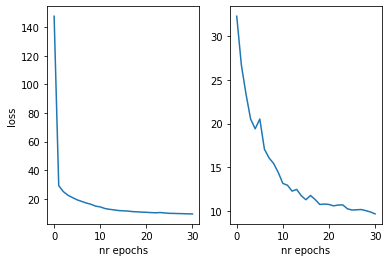

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(train_ELBO)
ax2.plot(validation_ELBO);
ax1.set_xlabel('nr epochs')
ax2.set_xlabel('nr epochs')
ax1.set_ylabel('loss');



1D: reconstructions


In [14]:
vae.eval()

x_original_list = []
y_list = []
x_reconstr_list = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size,1,28,28)
        x = x.to(device)
        
        x_reconstr, mu, log_sigma= vae(x)
        x_original_list.append(x)
        y_list.append(y)
        x_reconstr_list.append(x_reconstr)


100%|██████████| 100/100 [00:01<00:00, 72.51it/s]


1D: Make our own images

In [15]:
with torch.no_grad():
    noise = torch.randn(batch_size, 10).to(device)
    generated_images = vae.decoder(noise)

In [22]:
from datetime import datetime
def show_images(x, ncols=16):
    x = x.view(batch_size, 28, 28)


    fig, ax = plt.subplots(1, ncols, figsize=(40, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys_r")
        ax[idx].axis('off')
    time =  datetime.now().strftime('%H%M%S')
    fig.savefig(f'figure: {time}')

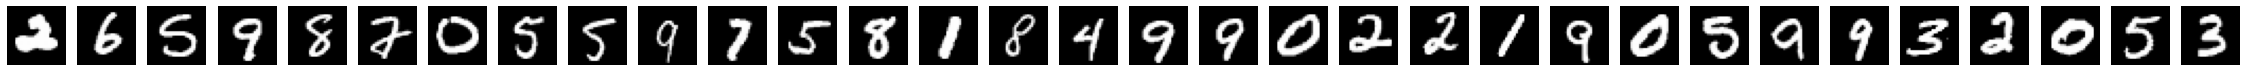

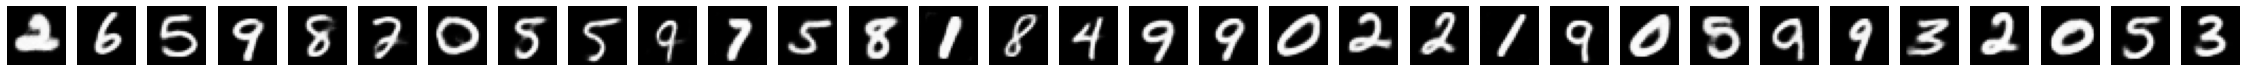

In [18]:
batch_idx = 0
show_images(x_original_list[batch_idx])
show_images(x_reconstr_list[batch_idx])

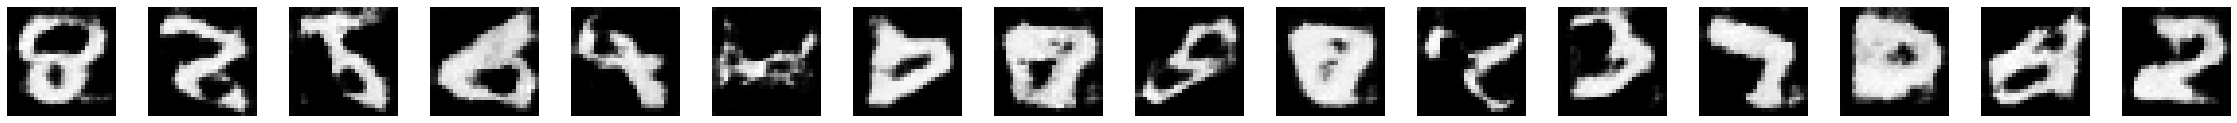

In [23]:
show_images(generated_images)